In [12]:
import pandas as pd
import numpy as np 
import rasterio
import rioxarray
import matplotlib.pyplot as plt 
import xarray as xr
import math
import seaborn as sns
sns.set()
sns.set_context("notebook")

class Analysis:
    def __init__(self) -> None:
        pass

    def get_pred_h(self, results):
        self.rf_results = rioxarray.open_rasterio(results, band_as_variable=True)
        
    def set_ground_truth(self, gt_tif):
        self.ground_truth = rioxarray.open_rasterio(gt_tif, band_as_variable=True)

    def set_test_data(self, test_data_tif):
        self.test_data = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data
    
    def get_difference(self):
        self.ground = self.ground_truth.rio.reproject_match(self.test_data)
        # self.ground = self.test_data.rio.reproject_match(self.ground_truth)

        self.difference = self.ground - self.test_data
        return self.difference 
    
    def calc_rmse(self):
        diff = self.test_data - self.ground
        diff_sq = diff ** 2
        mean = diff_sq.band_1.mean()
        rmse = math.sqrt(mean)
        return rmse

In [13]:
tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
tasman_pred_laplace = '../ICESAT/tasmania/tasmania_laplace.tif'
tasman_pred_idw = '../ICESAT/tasmania/tasmania_idw.tif'
tasman_pred_tin = '../ICESAT/tasmania/tasmania_tin.tif'
tasman_pred_nni = '../ICESAT/tasmania/tasmania_nni.tif'
tasman_pred_rf = '../ICESAT/tasmania/results/tasmania_pred_sklearn.tif'

<xarray.Dataset>
Dimensions:      (x: 184, y: 169)
Coordinates:
  * x            (x) float64 5.05e+05 5.051e+05 ... 5.232e+05 5.233e+05
  * y            (y) float64 5.258e+06 5.258e+06 ... 5.275e+06 5.275e+06
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


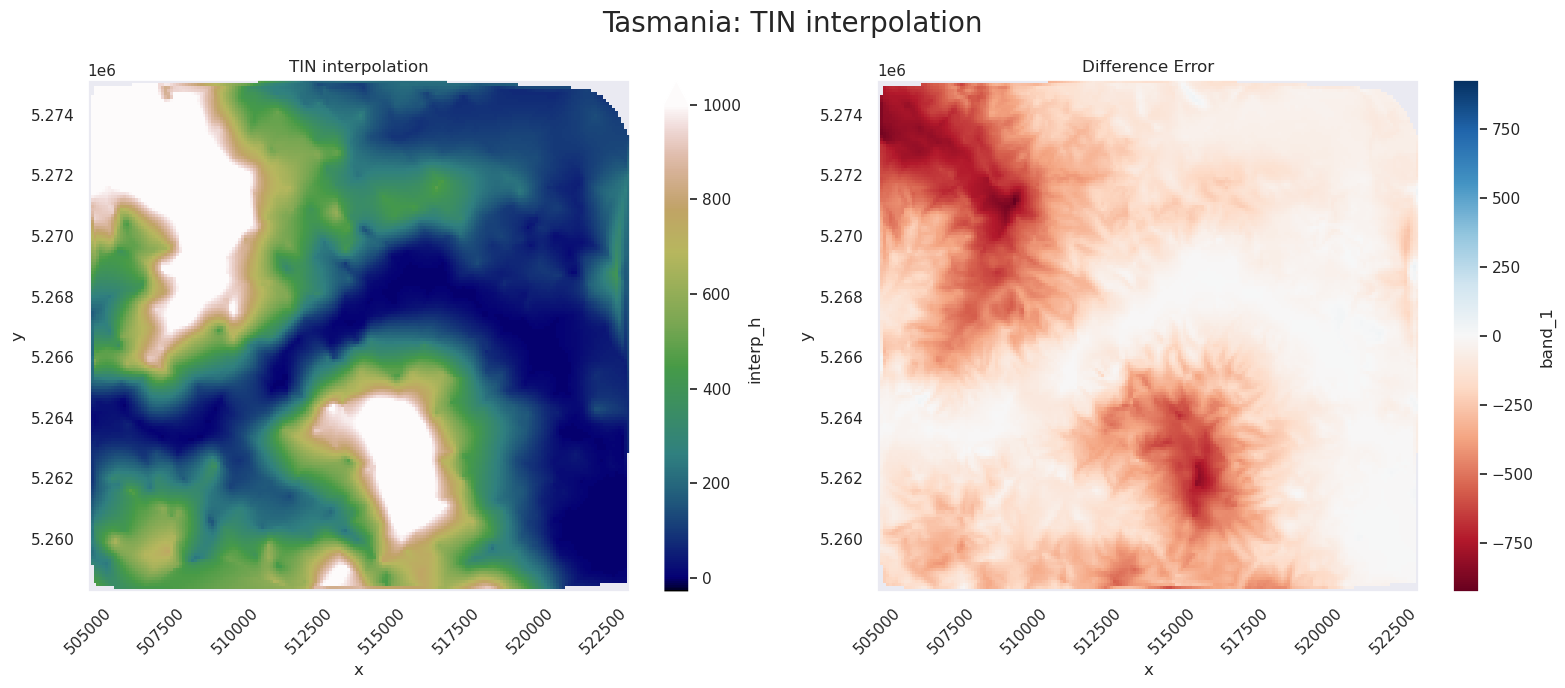

-927.1214037627369
44.113152072668015
-139.2361264989465
mean -206.56748660875317
std 197.06339715604548
rmse 285.4892450207866


In [170]:
tasman = Analysis()
tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_01.tif'
tasman.set_ground_truth(tasman_ground_truth)
tasman.set_test_data(tasman_pred_laplace)
# tasman.difference.band_1.plot()

def get_diff(dataset_ground, dataset_test):
    dataset_ground = dataset_ground.rio.reproject_match(dataset_test)
    difference = dataset_ground - dataset_test
    return difference 

# Crop Test Data
tasman_dataset1 = tasman.test_data.sel(
    x=slice(tasman.ground_truth['x'].min()+100, tasman.ground_truth['x'].max()-100),
    y=slice(tasman.ground_truth['y'].min()+100, tasman.ground_truth['y'].max()-100)
)

# tasman.ground_truth.band_1.plot(cmap='gist_earth', robust=True, vmin=-30.12726656, vmax=1000)
# plt.title('Ground Truth')
# plt.xticks(rotation=45)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

tasman.test_data.band_1.plot(cmap='gist_earth', robust=True, ax=axes[0], vmin=-30.12726656, vmax=1000)
axes[0].set_title('TIN interpolation')

difference = get_diff(tasman.ground_truth, tasman.test_data)
difference.band_1.plot(cmap='RdBu', ax=axes[1])
axes[1].set_title('Difference Error')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Adjust space between subplots
plt.suptitle("Tasmania: TIN interpolation", fontsize=20)
plt.tight_layout()
plt.show()

difference = difference.band_1.to_numpy()
difference.flatten()
difference = difference[~np.isnan(difference)]

print(np.min(difference))
print(np.max(difference))
print(np.median(difference))
print("mean", np.mean(difference))
print("std", np.std(difference))

rmse = math.sqrt(np.mean(difference**2))
print("rmse", rmse)


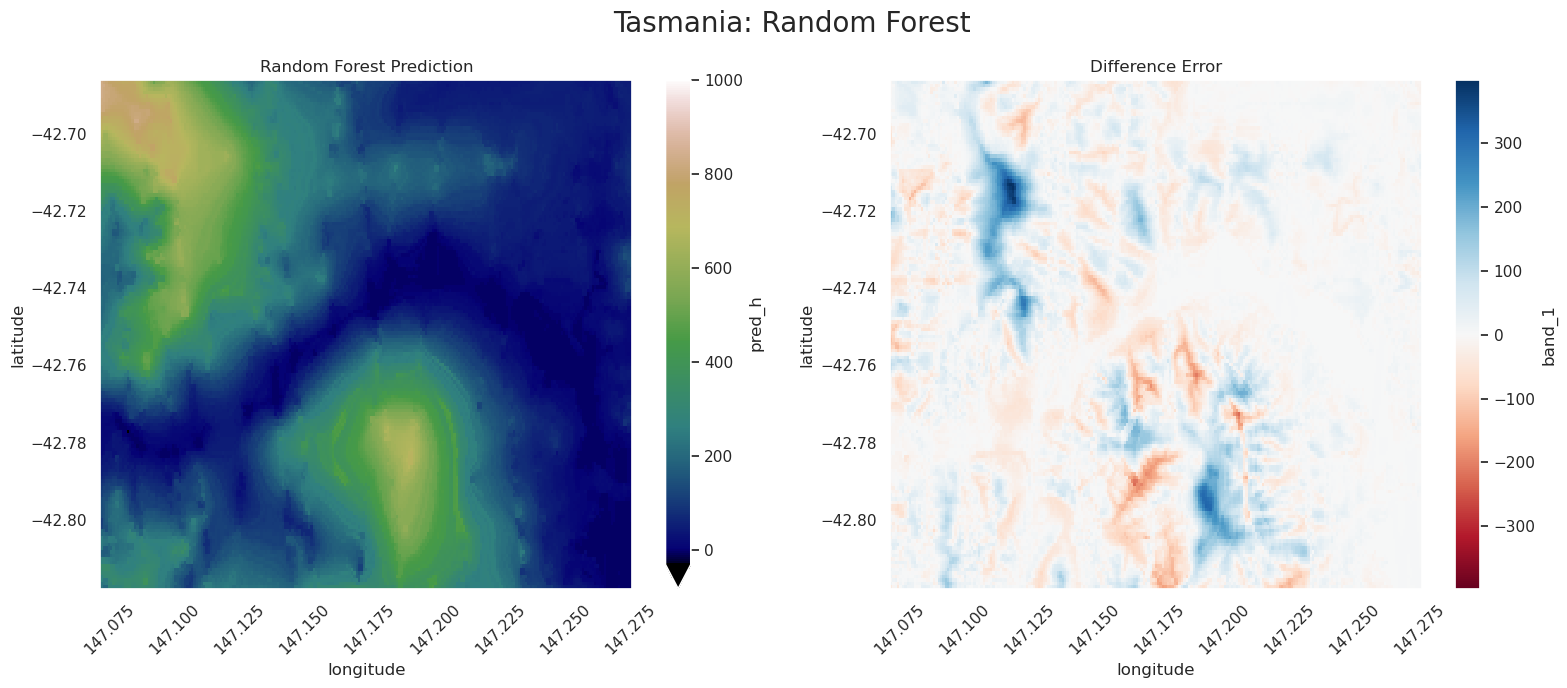

-226.69290127328972
397.7518997325807
2.2570513716679486
50.371362287993385
8.321087234011753
rmse 51.05403638797148


In [219]:
tasman = Analysis()
tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
tasman.set_ground_truth(tasman_ground_truth)
tasman.set_test_data(tasman_pred_rf)
# tasman.difference.band_1.plot()

def get_diff(dataset_ground, dataset_test):
    dataset_ground = dataset_ground.rio.reproject_match(dataset_test)
    difference = dataset_ground - dataset_test
    return difference 

# Crop Test Data
tasman_dataset1 = tasman.test_data.sel(
    x=slice(tasman.ground_truth['x'].min()+0.01, tasman.ground_truth['x'].max()-0.01),
    y=slice(tasman.ground_truth['y'].min()+0.01, tasman.ground_truth['y'].max()-0.01)
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

tasman_dataset1.band_1.plot(cmap='gist_earth', robust=True, ax=axes[0], vmin=-30.12726656, vmax=1000)
axes[0].set_title('Random Forest Prediction')

difference = get_diff(tasman.ground_truth, tasman_dataset1)
difference.band_1.plot(cmap='RdBu', ax=axes[1])
axes[1].set_title('Difference Error')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

# Adjust space between subplots
plt.suptitle("Tasmania: Random Forest", fontsize=20)
plt.tight_layout()
plt.show()

difference = difference.band_1.to_numpy()
difference.flatten()
print(np.min(difference))
print(np.max(difference))
print(np.median(difference))
print(np.std(difference))
print(np.mean(difference))

rmse = math.sqrt(np.mean(difference**2))
print("rmse", rmse)


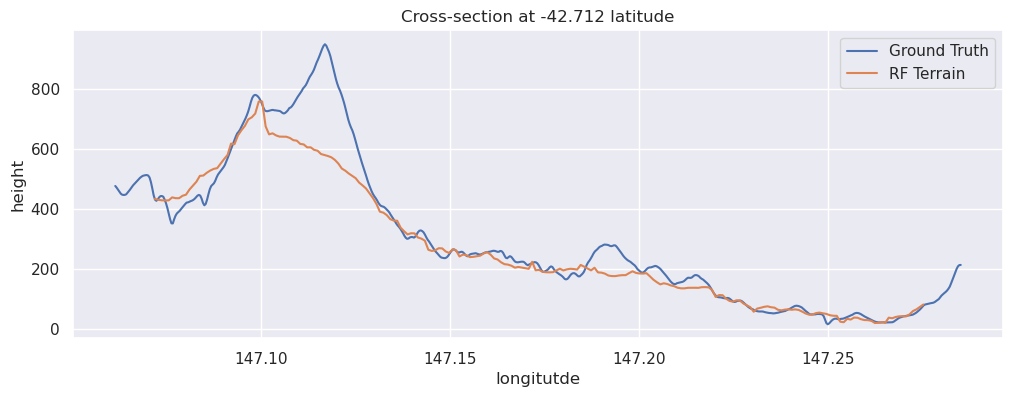

In [292]:
# cross_section_gnd = tasman_gnd.sel(y=-42.80, method='nearest')
# cross_section_test = tasman_dataset1.sel(y=-42.80, method='nearest')
target_lat = -42.712
# tasman_dataset1.band_1.plot(label="ground truth")
mask = tasman.ground_truth != -9999
filtered_data = tasman.ground_truth.where(mask, drop=True)

# filtered_data.band_1.plot(label="ground truth")
cross_section_gnd = filtered_data.sel(y=target_lat, method='nearest')
cross_section_test = tasman_dataset1.sel(y=target_lat, method='nearest')


# icesatpoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv')
# measurement_x = icesatpoints['lon'].values
# measurement_y = icesatpoints['lat'].values
# mask = np.abs(measurement_y - -42.71) <= 0.1

# target_y = -42.70
# tolerance = 0.01

# Filter the y-axis values based on the mask
# filtered_x = measurement_x[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]
# filtered_y = measurement_y[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]

plt.figure(figsize=(12, 4))
# plt.scatter(filtered_x, filtered_y, c='red', marker='o', label='Measurements', s=1)
cross_section_gnd.band_1.plot(label="Ground Truth")
cross_section_test.band_1.plot(label="RF Terrain")
plt.legend()
plt.xlabel('longitutde')
plt.ylabel('height')
plt.title(f'Cross-section at {target_lat} latitude')

plt.show()

(40028, 5)


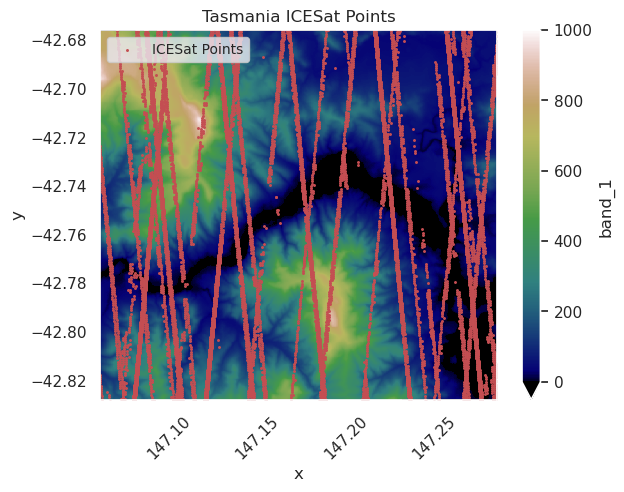

In [159]:
icesatpoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv')
x = icesatpoints['lon'].values
y = icesatpoints['lat'].values

tasman.ground_truth.band_1.plot(cmap='gist_earth', robust=True, vmax=1000, vmin=-1)
plt.scatter(x, y, marker='.', c='r', s=5, label='ICESat Points')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.title("Tasmania ICESat Points")
plt.show()

(1000, 3)


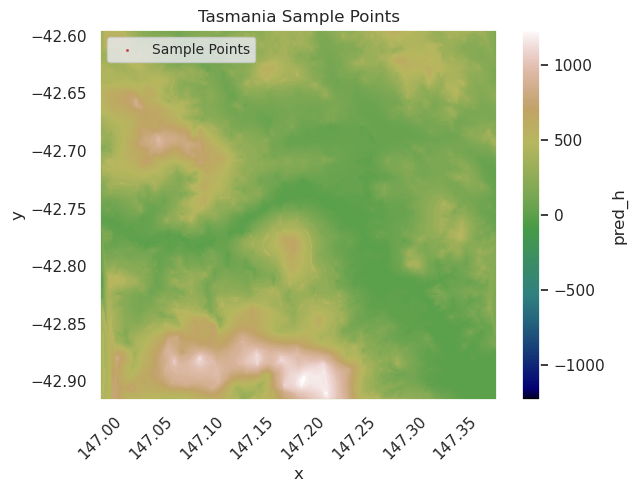

In [160]:
## Error Metrics
tasmaniapoints = pd.read_csv('../ICESAT/tasmania/tasman_samples.csv', delimiter=' ')
x = tasmaniapoints['x'].values
y = tasmaniapoints['y'].values

tasman.test_data.band_1.plot(cmap='gist_earth')
plt.scatter(x, y, marker='.', c='r', s=5, label='Sample Points')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.title("Tasmania Sample Points")
plt.show()

In [112]:
Diff = tasman.difference.band_1.to_numpy()
Diff.flatten()
Diff = Diff[~np.isnan(Diff)]
print("Max", np.max(Diff))
print("Min", np.min(Diff))
print("Median", np.median(Diff))
print("STD", np.std(Diff))

Max 82.99376424159867
Min -967.7290345759709
Median -138.02174346772887
STD 200.52385200726113
